<a href="https://colab.research.google.com/github/OliverMaerz/AIND-Isolation/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 v2

Generated with data from Johns Hopkins CSSE: https://github.com/CSSEGISandData




Set the countries we want to look at:

In [0]:
selected_countries = ['Argentina', 'Spain', 'Italy', 'Brazil', 'Chile', 'Germany', 'US', 'France']

First step is to download the Johns Hopkins CSSE global dataset for confirmed Covid19 cases:

In [52]:
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87580  100 87580    0     0   706k      0 --:--:-- --:--:-- --:--:--  706k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67769  100 67769    0     0   444k      0 --:--:-- --:--:-- --:--:--  444k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73395  100 73395    0     0   607k      0 --:--:-- --:--:-- --:--:--  607k


Next, import the libraries we will use for processing and plotting the data:

In [0]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [30, 15]
import numpy as np
import pandas as pd

Load the downloaded dataset (csv file) into a Pandas dataframe and remove some columns we will not use:

In [0]:
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, error_bad_lines=False)
recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, error_bad_lines=False)

In [73]:
recovered_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188,207,220,228,252,260
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403,410,422,431,455,470
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651,1702,1779
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344,344,385,398,423,468
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5
248,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4
249,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
250,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Define some helper functions

In [0]:
# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & df['Province/State'].isnull()].copy()
    selected_df.set_index('Country/Region', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df

# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    return diff_df
     

Calculate new cases

In [147]:
selected_confirmed_df = get_selected_countries(confirmed_df)
new_confirmed_df = get_difference_between_days(selected_confirmed_df)
new_confirmed_df

,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-07,2020-02-08,2020-02-09,2020-02-11,2020-02-13,2020-02-15,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,...,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,0.0,5.0,2.0,0.0,12.0,3.0,11.0,...,108.0,35.0,86.0,0.0,115.0,87.0,101.0,55.0,75.0,234.0,0.0,79.0,132.0,186.0,0.0,103.0,74.0,87.0,80.0,180.0,0.0,167.0,66.0,69.0,166.0,128.0,98.0,89.0,81.0,102.0,90.0,113.0,291.0,172.0,173.0,112.0,111.0,124.0,158.0,143.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,9.0,0.0,7.0,5.0,6.0,7.0,14.0,99.0,0.0,11.0,...,525.0,378.0,323.0,307.0,431.0,432.0,487.0,352.0,323.0,1138.0,1119.0,1208.0,1012.0,1304.0,770.0,1031.0,1873.0,2136.0,1922.0,1546.0,1089.0,1465.0,1238.0,1832.0,3058.0,2105.0,3257.0,2976.0,1996.0,2089.0,2336.0,2678.0,4279.0,4007.0,5281.0,3776.0,4346.0,5789.0,6450.0,7502.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,5.0,10.0,0.0,20.0,18.0,13.0,...,95.0,114.0,176.0,220.0,164.0,304.0,299.0,230.0,310.0,289.0,293.0,373.0,333.0,424.0,310.0,344.0,301.0,430.0,426.0,529.0,426.0,286.0,312.0,392.0,356.0,534.0,445.0,478.0,358.0,419.0,325.0,464.0,516.0,494.0,552.0,473.0,482.0,552.0,520.0,1138.0
France,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,4.0,20.0,19.0,43.0,30.0,61.0,13.0,81.0,92.0,276.0,296.0,177.0,83.0,575.0,497.0,0.0,1380.0,808.0,30.0,...,1736.0,3838.0,2448.0,2929.0,3922.0,3809.0,4611.0,2599.0,4376.0,7578.0,4861.0,2116.0,5233.0,4267.0,1873.0,3912.0,3777.0,3881.0,4286.0,4342.0,3114.0,26843.0,3665.0,4959.0,3216.0,12471.0,1979.0,-17.0,4902.0,2380.0,2733.0,-2206.0,2311.0,1610.0,1656.0,555.0,3742.0,3016.0,-2512.0,671.0
Germany,0.0,0.0,0.0,1.0,3.0,0.0,1.0,3.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,19.0,2.0,31.0,51.0,29.0,37.0,66.0,220.0,188.0,129.0,241.0,136.0,281.0,451.0,170.0,1597.0,910.0,1210.0,...,2660.0,4183.0,3930.0,4337.0,6615.0,6933.0,6824.0,4400.0,4790.0,4923.0,6064.0,6922.0,6365.0,4933.0,4031.0,3251.0,4289.0,5633.0,4885.0,3990.0,2737.0,2946.0,2218.0,1287.0,3394.0,2945.0,3699.0,1945.0,1842.0,1881.0,1226.0,2357.0,2481.0,1870.0,1514.0,1257.0,988.0,1154.0,1627.0,1470.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17.0,42.0,93.0,74.0,93.0,131.0,202.0,233.0,240.0,566.0,342.0,466.0,587.0,769.0,778.0,1247.0,1492.0,1797.0,977.0,2313.0,0.0,5198.0,3497.0,3590.0,...,5560.0,4789.0,5249.0,5210.0,6203.0,5909.0,5974.0,5217.0,4050.0,4053.0,4782.0,4668.0,4585.0,4805.0,4316.0,3599.0,3039.0,3836.0,4204.0,3951.0,4694.0,4092.0,3153.0,2972.0,2667.0,3786.0,3493.0,3491.0,3047.0,2256.0,2729.0,3370.0,2646.0,3021.0,2357.0,2324.0,1739.0,2091.0,2086.0,1872.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,2.0,17.0,13.0,39.0,36.0,45.0,57.0,37.0,141.0,100.0,173.0,400.0,622.0,582.0,0.0,2955.0,1159.0,1407.0,...,3394.0,6368.0,4749.0,9630.0,8271.0,7933.0,7516.0,6875.0,7846.0,7967.0,8195.0,7947.0,7134.0,6969.0,5478.0,5029.0,5

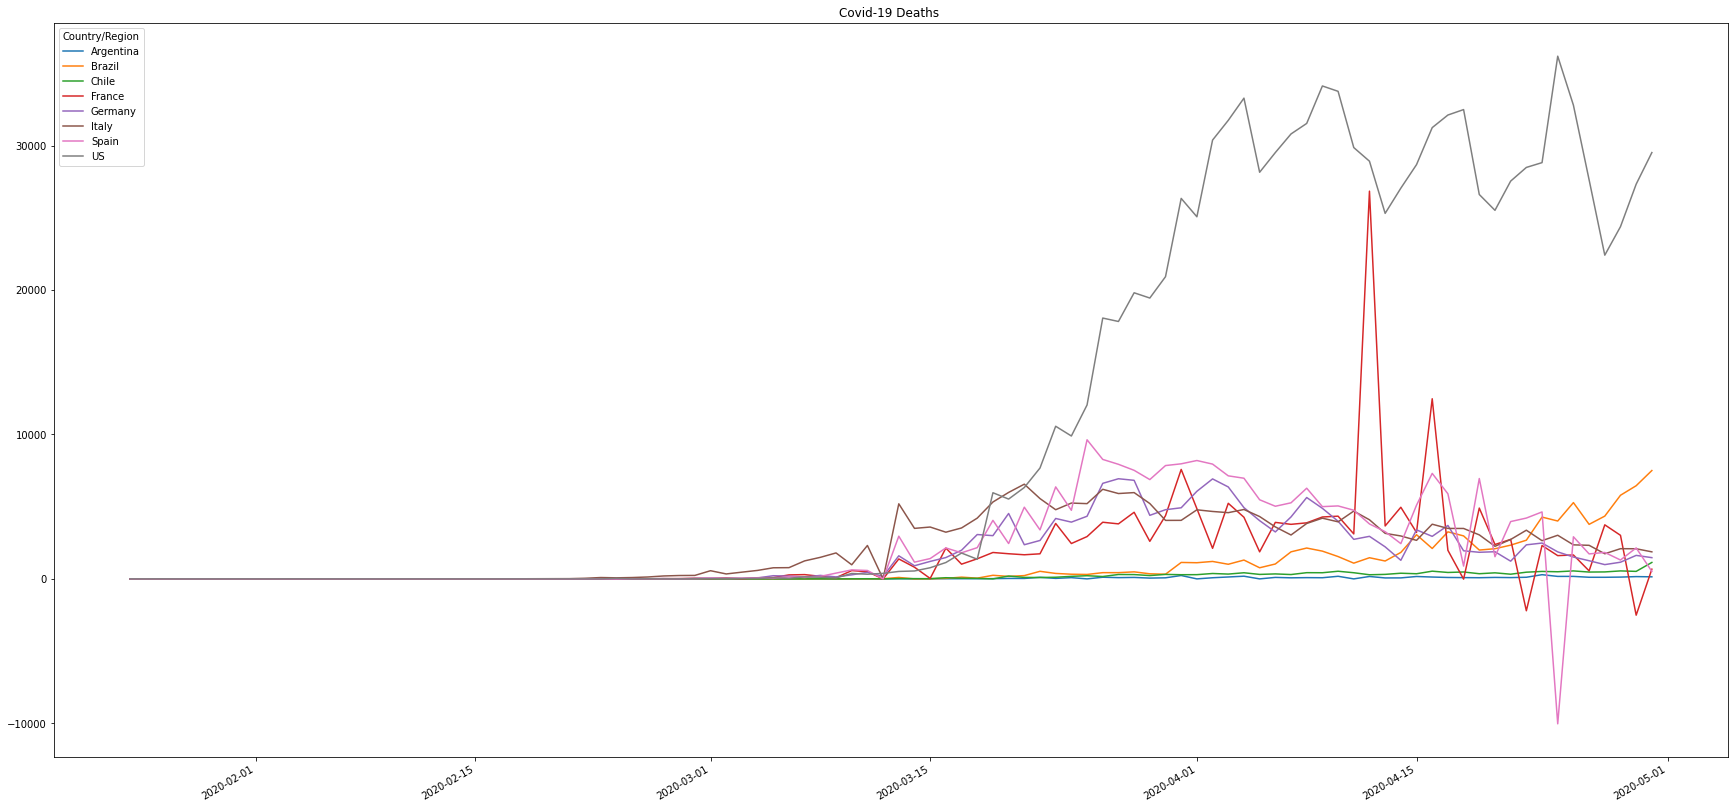

In [174]:
# prepare data for plot; first transpose 
new_confirmed_transpose_df = new_confirmed_df.transpose()
# smooth out (interpolate)
# new_deaths_interpolate_df = new_deaths_transpose_df.resample('H').interpolate(method='cubic')
# plot it
new_confirmed_transpose_df.plot(kind='line', title='Covid-19 Deaths ', logy=False)

In [148]:
selected_deaths_df = get_selected_countries(deaths_df)
new_deaths_df = get_difference_between_days(selected_deaths_df)
new_deaths_df

,2020-02-15,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,4.0,4.0,1.0,8.0,3.0,4.0,1.0,4.0,8.0,7.0,9.0,10.0,1.0,7.0,7.0,5.0,9.0,4.0,8.0,6.0,3.0,4.0,11.0,5.0,13.0,11.0,9.0,7.0,5.0,10.0,7.0,4.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,4.0,10.0,9.0,12.0,13.0,18.0,15.0,19.0,25.0,23.0,42.0,39.0,84.0,35.0,86.0,41.0,78.0,122.0,133.0,131.0,107.0,67.0,99.0,105.0,204.0,204.0,188.0,217.0,213.0,108.0,125.0,154.0,165.0,425.0,373.0,353.0,229.0,317.0,480.0,430.0,493.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,2.0,4.0,5.0,7.0,3.0,6.0,5.0,9.0,8.0,8.0,7.0,2.0,10.0,2.0,11.0,11.0,10.0,7.0,6.0,8.0,13.0,8.0,6.0,7.0,8.0,9.0,9.0,9.0,11.0
France,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,2.0,8.0,0.0,14.0,15.0,0.0,31.0,12.0,0.0,57.0,0.0,0.0,95.0,207.0,112.0,112.0,186.0,240.0,231.0,365.0,299.0,319.0,292.0,418.0,499.0,880.0,984.0,1120.0,1053.0,518.0,833.0,1417.0,541.0,1341.0,987.0,635.0,561.0,574.0,762.0,1438.0,753.0,761.0,642.0,395.0,547.0,531.0,544.0,516.0,389.0,369.0,242.0,437.0,367.0,427.0,289.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,2.0,6.0,7.0,4.0,16.0,23.0,17.0,10.0,29.0,34.0,49.0,61.0,75.0,91.0,100.0,112.0,130.0,145.0,187.0,168.0,169.0,140.0,226.0,206.0,333.0,258.0,160.0,-31.0,286.0,172.0,100.0,510.0,248.0,300.0,107.0,127.0,276.0,171.0,246.0,296.0,185.0,117.0,99.0,150.0,188.0,153.0,156.0
Italy,0.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,4.0,8.0,5.0,18.0,27.0,28.0,41.0,49.0,36.0,133.0,97.0,168.0,196.0,0.0,439.0,175.0,368.0,349.0,345.0,475.0,427.0,627.0,793.0,651.0,601.0,743.0,683.0,712.0,919.0,889.0,756.0,812.0,837.0,727.0,760.0,766.0,681.0,525.0,636.0,604.0,542.0,610.0,570.0,619.0,431.0,566.0,602.0,578.0,525.0,575.0,482.0,433.0,454.0,534.0,437.0,464.0,420.0,415.0,260.0,333.0,382.0,323.0,285.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,7.0,11.0,7.0,19.0,1.0,78.0,62.0,94.0,53.0,191.0,90.0,207.0,213.0,332.0,397.0,539.0,497.0,839.0,718.0,773.0,844.0,821.0,913.0,748.0,923.0,961.0,850.0,749.0,694.0,700.0,704.0,747.0,655.0,634.0,525.0,603.0,547.0,300.0,652.0,607.0,687.0,41.0,410.0,399.0,430.0,435.0,440.0,367.0,378.0,288.0,331.0,301.0,453.0,268.0
US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,6.0,8.0,5.0,8.0,9.0,15.0,26.0,34.0,31.0,94.0,91.0,93.0,144.0,200.0,222.0,308.0,410.0,539.0,466.0,689.0,772.0,1175.0,1134.0,1420.0,1325.0,1609.0,1520.0,1519.0,2297.0,2079.0,1985.0,2078.0,2009.0,1744.0,1784.0,2392.0,2472.0,2093.0,2584.0,2342.0,1192.0,1714.0,2427.0,2326.0,2312.0,1769.0,2262.0,1126.0,1378.0,2096.0,2612.0,2029.0


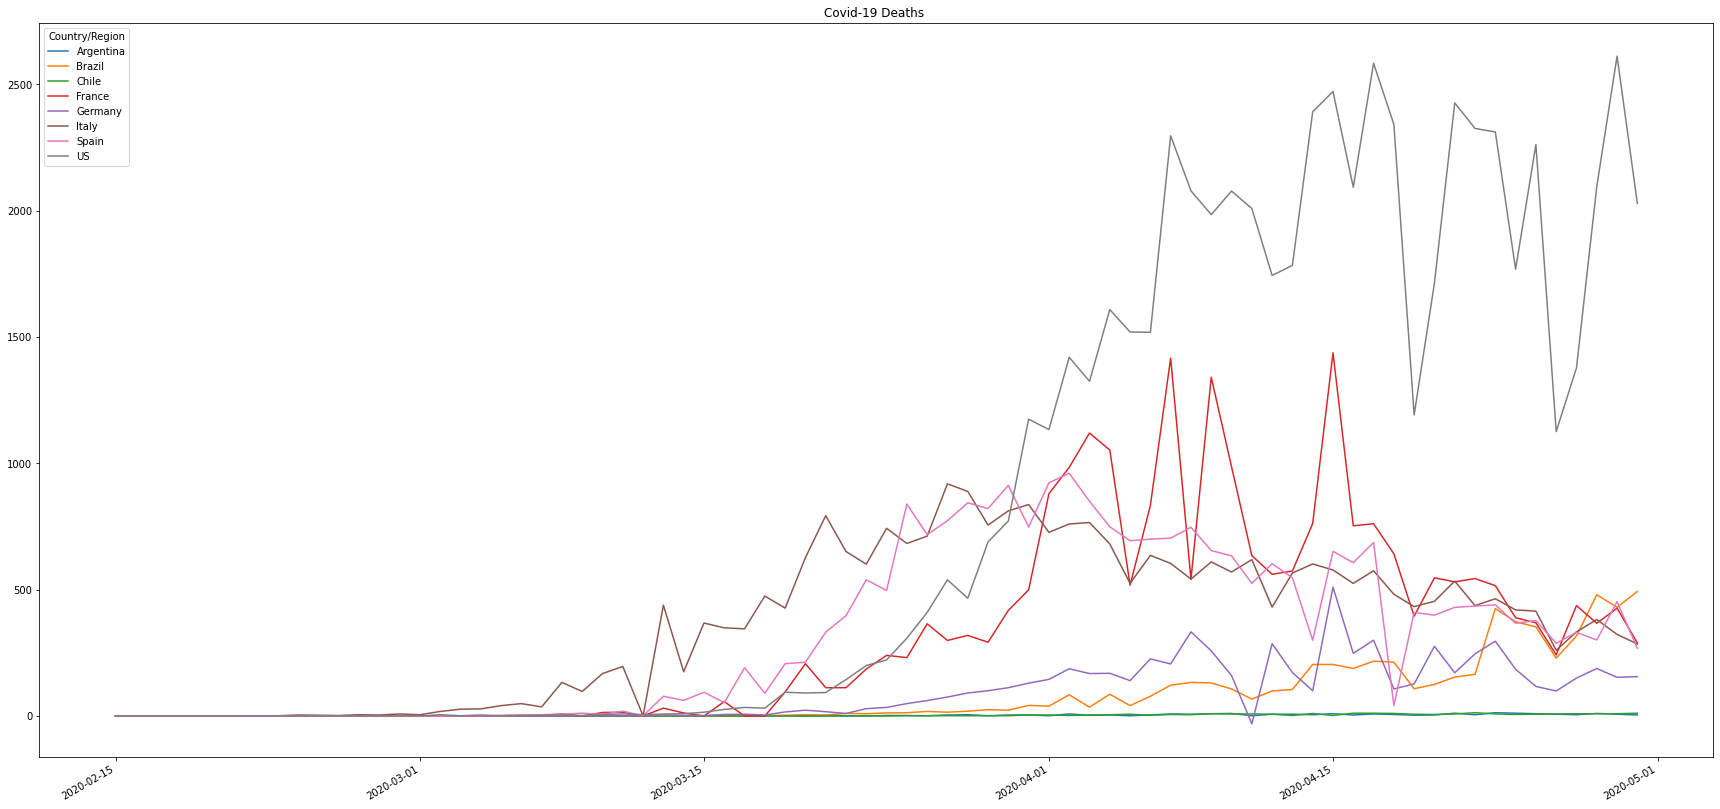

In [173]:
# prepare data for plot; first transpose 
new_deaths_transpose_df = new_deaths_df.transpose()
# smooth out (interpolate)
# new_deaths_interpolate_df = new_deaths_transpose_df.resample('H').interpolate(method='cubic')
# plot it
new_deaths_transpose_df.plot(kind='line', title='Covid-19 Deaths ', logy=False)


In [149]:
selected_recovered_df = get_selected_countries(recovered_df)
new_recovered_df = get_difference_between_days(selected_recovered_df)
new_recovered_df

,2020-02-09,2020-02-12,2020-02-13,2020-02-15,2020-02-18,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,11.0,9.0,0.0,0.0,156.0,12.0,8.0,8.0,10.0,13.0,1.0,45.0,13.0,20.0,7.0,10.0,65.0,28.0,47.0,44.0,37.0,35.0,35.0,19.0,24.0,28.0,103.0,32.0,47.0,57.0,54.0,77.0,33.0,22.0,30.0,64.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,114.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,2873.0,10980.0,0.0,0.0,0.0,8104.0,0.0,861.0,2327.0,1255.0,1082.0,1505.0,992.0,990.0,1402.0,1588.0,1803.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,9.0,5.0,0.0,21.0,18.0,14.0,81.0,0.0,78.0,101.0,92.0,101.0,90.0,110.0,170.0,217.0,159.0,297.0,293.0,195.0,308.0,279.0,291.0,362.0,322.0,414.0,303.0,338.0,293.0,417.0,418.0,523.0,419.0,278.0,303.0,383.0,347.0,523.0
France,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2188.0,1043.0,657.0,1048.0,752.0,0.0,1502.0,725.0,1517.0,1490.0,1494.0,1580.0,1430.0,745.0,1067.0,2087.0,1917.0,1952.0,1726.0,1459.0,795.0,532.0,1087.0,2150.0,1857.0,1608.0,1563.0,595.0,831.0,1772.0,1476.0,1431.0,1405.0,1101.0,309.0,610.0,1373.0,1342.0,1248.0
Germany,0.0,0.0,1.0,0.0,11.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,21.0,0.0,0.0,21.0,0.0,38.0,8.0,67.0,53.0,33.0,2977.0,304.0,2126.0,985.0,1823.0,730.0,4289.0,2600.0,2600.0,3740.0,2135.0,1825.0,2300.0,0.0,7381.0,10219.0,6107.0,1506.0,3487.0,2900.0,4000.0,3900.0,4400.0,4400.0,6114.0,2286.0,2600.0,3500.0,3700.0,4200.0,3900.0,6500.0,0.0,2200.0,2500.0,2900.0,3000.0,3100.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,2.0,42.0,1.0,0.0,37.0,66.0,11.0,116.0,138.0,109.0,66.0,33.0,102.0,0.0,321.0,0.0,394.0,527.0,369.0,414.0,192.0,1084.0,415.0,0.0,1632.0,952.0,1302.0,1036.0,999.0,589.0,1434.0,646.0,1590.0,1109.0,1118.0,1431.0,1480.0,1238.0,819.0,1022.0,1555.0,2099.0,1979.0,1985.0,2079.0,1677.0,1224.0,1695.0,962.0,2072.0,2563.0,2200.0,2128.0,1822.0,2723.0,2943.0,3033.0,2922.0,2622.0,1808.0,1696.0,2317.0,2311.0,4693.0
Spain,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,2.0,0.0,151.0,0.0,10.0,324.0,0.0,13.0,498.0,53.0,26.0,481.0,537.0,450.0,1219.0,1573.0,1648.0,2342.0,2928.0,2424.0,2071.0,2479.0,3388.0,4096.0,3770.0,3706.0,3861.0,2357.0,2771.0,4813.0,4144.0,3503.0,3441.0,3282.0,2336.0,2777.0,3349.0,3944.0,0.0,0.0,2560.0,3230.0,1927.0,3401.0,3335.0,3105.0,3353.0,2664.0,2503.0,1673.0,6399.0,3103.0
US,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,88.0,16.0,26.0,29.0,2.0,170.0,13.0,320.0,188.0,203.0,1593.0,2979.0,1380.0,1450.0,527.0,706.0,4945.0,2796.0,2133.0,2182.0,1796.0,1851.0,3380.0,2480.0,1718.0,10494.0,4281.0,4333.0,2607.0,3842.0,6295.0,5497.0,1992.0,2875.0,2162.0

In [129]:
death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country/Region
Argentina    0.049232
Brazil       0.068886
Chile        0.014167
France       0.147052
Germany      0.040630
Italy        0.136117
Spain        0.114991
US           0.058906
Name: 4/30/20, dtype: float64

In [130]:
death_rate_vs_recovered = selected_deaths_df.iloc[:,-1] \
                          / selected_recovered_df.iloc[:,-1] 
death_rate_vs_recovered

Country/Region
Argentina    0.173567
Brazil       0.167135
Chile        0.026457
France       0.492683
Germany      0.053628
Italy        0.368253
Spain        0.219036
US           0.409206
Name: 4/30/20, dtype: float64

### Calculate reproduction number 
Last four days vs. previous four days 

```Reff(t) = (N(t)+N(t-1)+N(t-2)+N(t-3)) / (N(t-4)+N(t-5)+N(t-6)+N(t-7))``` 

The reproduction number should be <1 to avoid exponential growth of cases

In [131]:
reproduction_df = (selected_confirmed_df.iloc[:,-1] \
                   + selected_confirmed_df.iloc[:,-2] \
                   + selected_confirmed_df.iloc[:,-3] \
                   + selected_confirmed_df.iloc[:,-4]) \
                  / (selected_confirmed_df.iloc[:,-5] \
                   + selected_confirmed_df.iloc[:,-6] \
                   + selected_confirmed_df.iloc[:,-7] \
                   + selected_confirmed_df.iloc[:,-8])
reproduction_df

Country/Region
Argentina    1.144692
Brazil       1.357832
Chile        1.174509
France       1.041222
Germany      1.033430
Italy        1.043789
Spain        1.020538
US           1.117344
dtype: float64